### Домашнее задание # 4
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
%matplotlib inline
import matplotlib as plt
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


C:\Users\lqw\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('data.csv',encoding='utf8')

In [3]:
df

recency  history  used_discount  used_bogo   zip_code  is_referral  \
0           10   142.44              1          0  Surburban            0   
1            6   329.08              1          1      Rural            1   
2            7   180.65              0          1  Surburban            1   
3            9   675.83              1          0      Rural            1   
4            2    45.34              1          0      Urban            0   
...        ...      ...            ...        ...        ...          ...   
63995       10   105.54              1          0      Urban            0   
63996        5    38.91              0          1      Urban            1   
63997        6    29.99              1          0      Urban            1   
63998        1   552.94              1          0  Surburban            1   
63999        1   472.82              0          1  Surburban            0   

            channel            offer  conversion  
0             Phone  Buy One Get One           0  
1               Web         No Offer           0  
2               Web  Buy One Get One           0  
3               Web         Discount           0  
4               Web  Buy One Get One           0  
...             ...              ...         ...  
63995           Web         Discount           0  
63996         Phone         Discount           0  
63997         Phone         Discount           0  
63998  Multichannel  Buy One Get One           0  
63999           Web         Discount           0  

[64000 rows x 9 columns]

In [4]:
# months since last purchase
df['recency'].value_counts(normalize=True)

1     0.139875
10    0.118203
2     0.117766
9     0.100641
3     0.092250
4     0.079328
6     0.071953
5     0.070469
7     0.063719
11    0.054750
8     0.054609
12    0.036437
Name: recency, dtype: float64

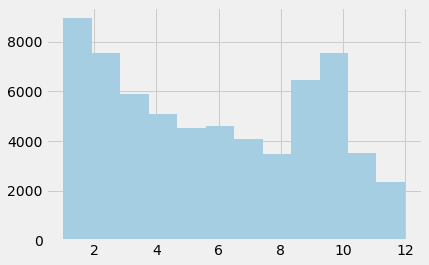

In [5]:
df['recency'].hist(bins=12)

In [6]:
df['recency'].describe()

count    64000.000000
mean         5.763734
std          3.507592
min          1.000000
25%          2.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: recency, dtype: float64

In [7]:
# $value of the historical purchases
df['history'].describe()

count    64000.000000
mean       242.085656
std        256.158608
min         29.990000
25%         64.660000
50%        158.110000
75%        325.657500
max       3345.930000
Name: history, dtype: float64

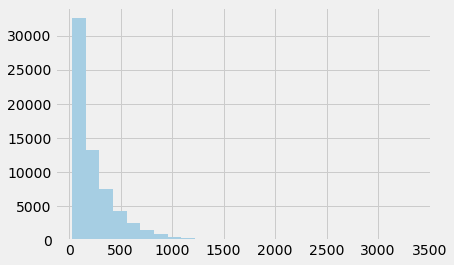

In [8]:
df['history'].hist(bins=25)

In [9]:
# indicates if the customer used a discount before
df['used_discount'].value_counts(normalize=True)

1    0.551031
0    0.448969
Name: used_discount, dtype: float64

In [10]:
# indicates if the customer used a buy one get one before
df['used_bogo'].value_counts(normalize=True)

1    0.549719
0    0.450281
Name: used_bogo, dtype: float64

In [11]:
# class of the zip code as Suburban/Urban/Rural
df['zip_code'].value_counts(normalize=True)

Surburban    0.449625
Urban        0.400953
Rural        0.149422
Name: zip_code, dtype: float64

In [12]:
# indicates if the customer was acquired from referral channel
df['is_referral'].value_counts(normalize=True)

1    0.50225
0    0.49775
Name: is_referral, dtype: float64

In [13]:
# channels that the customer using, Phone/Web/Multichannel
df['channel'].value_counts(normalize=True)

Web             0.440891
Phone           0.437828
Multichannel    0.121281
Name: channel, dtype: float64

In [14]:
df['offer'].value_counts(normalize=True)

Buy One Get One    0.334172
Discount           0.332922
No Offer           0.332906
Name: offer, dtype: float64

In [15]:
df['conversion'].value_counts(normalize=True)

0    0.853219
1    0.146781
Name: conversion, dtype: float64

In [16]:
df_work = df.copy()

In [17]:
df_work.rename(columns={'conversion':'target','offer':'treatment'},inplace=True)

In [18]:
df_work.loc[:,'treatment'] = df['offer'].apply(lambda x: 0 if x == 'No Offer' else 1)

In [19]:
df_work = pd.concat([df_work.drop(['zip_code','channel'],axis=1) ,  \
            pd.get_dummies(df_work['channel'],prefix='channel'),pd.get_dummies(df_work['zip_code'],prefix='zip_code')],1 )

In [20]:
df_work['recency']=StandardScaler().fit_transform(df['recency'].to_numpy().reshape(-1,1))
df_work['history']=StandardScaler().fit_transform(df['history'].to_numpy().reshape(-1,1))

In [21]:
df_work

recency   history  used_discount  used_bogo  is_referral  treatment  \
0      1.207751 -0.389003              1          0            0          1   
1      0.067359  0.339614              1          1            1          0   
2      0.352457 -0.239836              0          1            1          1   
3      0.922653  1.693278              1          0            1          1   
4     -1.073034 -0.768068              1          0            0          1   
...         ...       ...            ...        ...          ...        ...   
63995  1.207751 -0.533055              1          0            0          1   
63996 -0.217739 -0.793170              0          1            1          1   
63997  0.067359 -0.827992              1          0            1          1   
63998 -1.358132  1.213532              1          0            1          1   
63999 -1.358132  0.900755              0          1            0          1   

       target  channel_Multichannel  channel_Phone  channel_Web  \
0           0                     0              1            0   
1           0                     0              0            1   
2           0                     0              0            1   
3           0                     0              0            1   
4           0                     0              0            1   
...       ...                   ...            ...          ...   
63995       0                     0              0            1   
63996       0                     0              1            0   
63997       0                     0              1            0   
63998       0                     1              0            0   
63999       0                     0              0            1   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  
0                   0                   1               0  
1                   1                   0               0  
2                   0                   1               0  
3                   1                   0               0  
4                   0                   0               1  
...               ...                 ...             ...  
63995               0                   0               1  
63996               0                   0               1  
63997               0                   0               1  
63998               0                   1               0  
63999               0                   1               0  

[64000 rows x 13 columns]

In [22]:
train_ind,test_ind = train_test_split(df_work.index,test_size=0.25, random_state=1)
df_features = df_work.drop(['target','treatment'],axis=1)

X_train = df_features.loc[train_ind, :]
y_train = df_work.loc[train_ind, 'target']
treat_train = df_work.loc[train_ind, 'treatment']

X_val = df_features.loc[test_ind, :]
y_val = df_work.loc[test_ind, 'target']
treat_val =  df_work.loc[test_ind, 'treatment']

# X_train_full = df_features.loc[indices_train, :]
# y_train_full = df_train.loc[:, 'target']
# treat_train_full = df_train.loc[:, 'treatment_flg']


models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
    
}

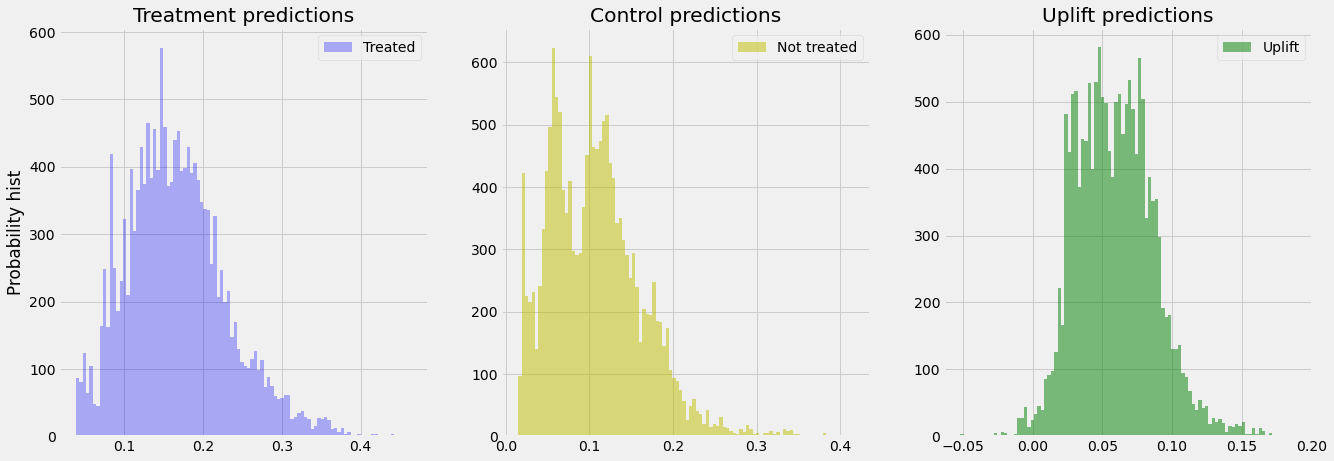

In [23]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=6, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)


models_results['approach'].append('SoloModel_catboost')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

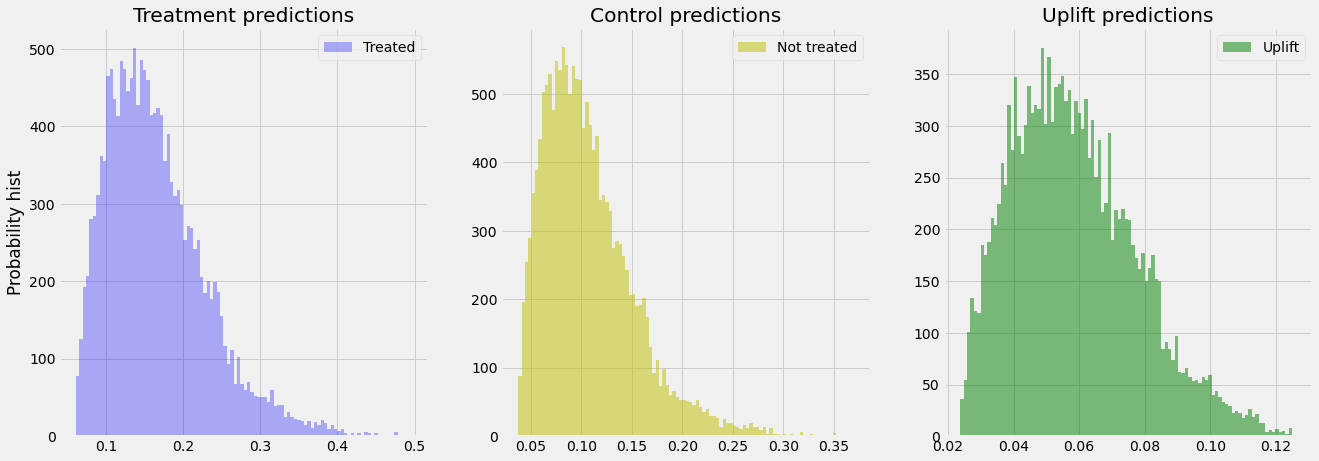

In [24]:
sm = SoloModel(LogisticRegression())
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)


models_results['approach'].append('SoloModel_logreg')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);




It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


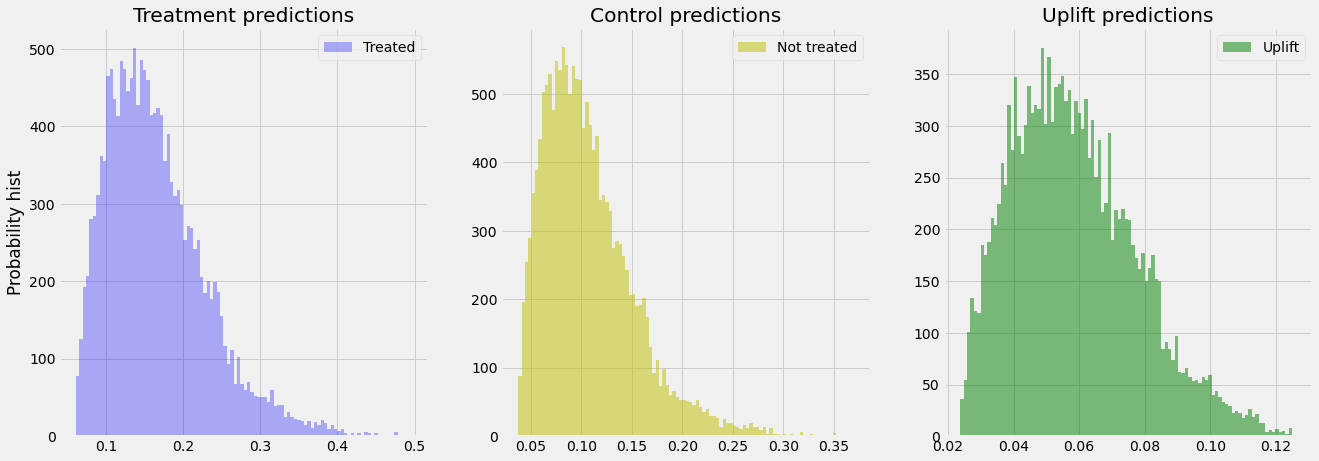

In [25]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=6, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)


models_results['approach'].append('ClassTransformation_catbost')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);


It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


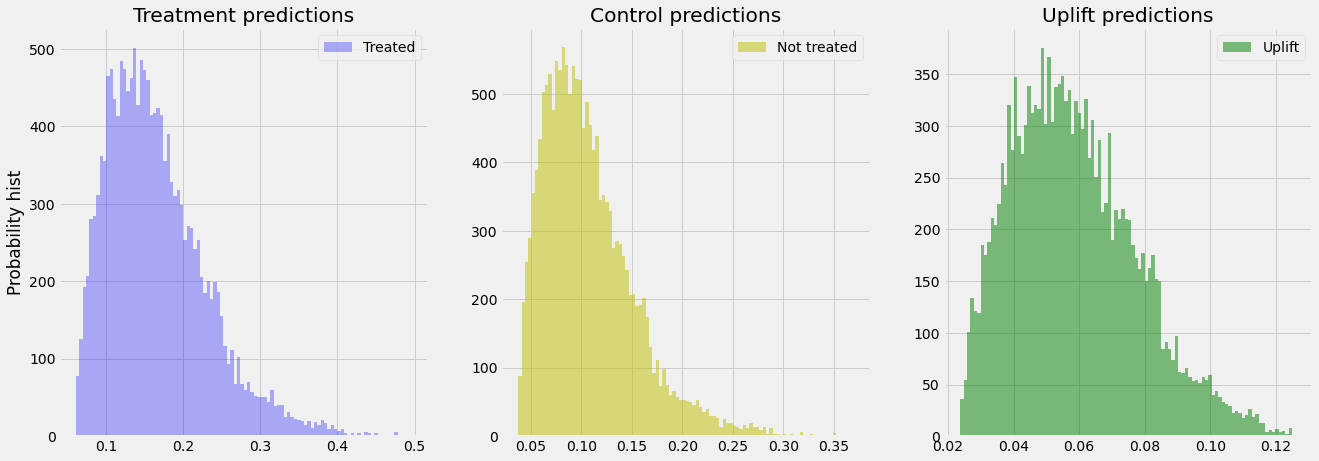

In [26]:
ct = ClassTransformation(LogisticRegression())
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)


models_results['approach'].append('ClassTransformation_logreg')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

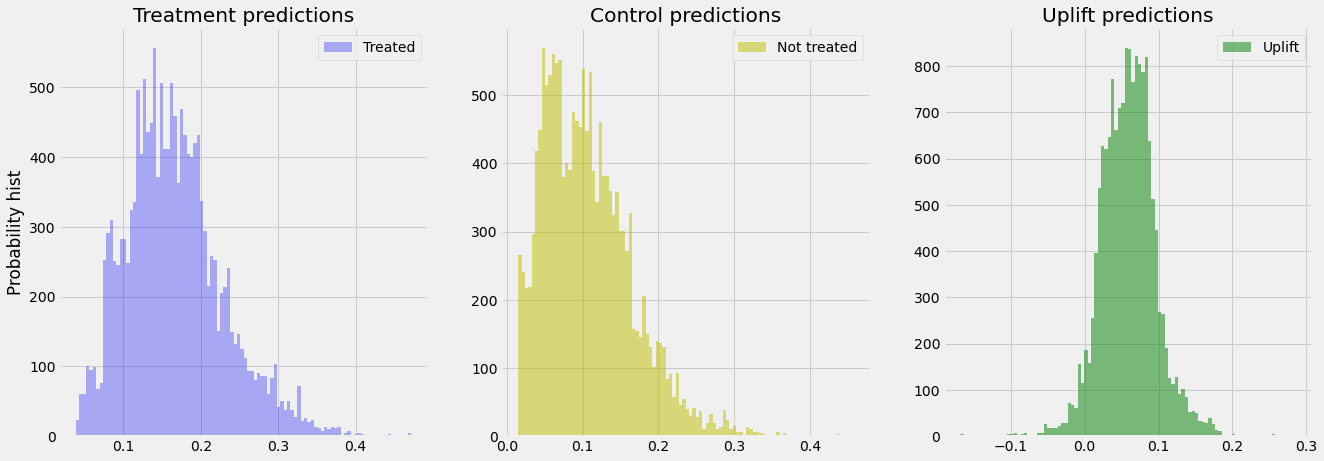

In [27]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_catboost')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

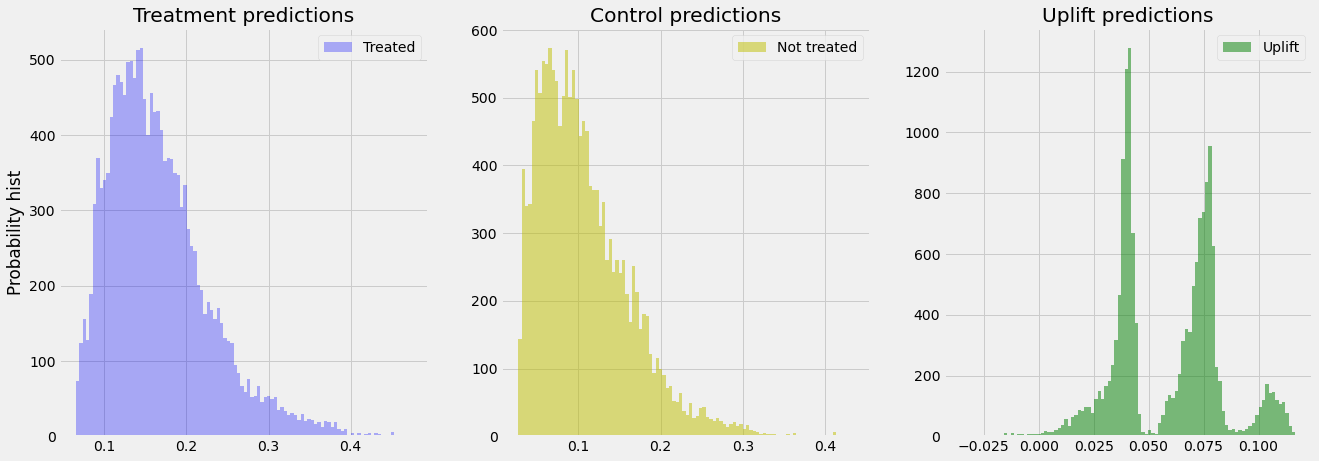

In [28]:
tm = TwoModels(
    estimator_trmnt=LogisticRegression(), 
    estimator_ctrl=LogisticRegression(), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_logreg')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [29]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

approach  uplift@10%  uplift@20%  uplift@30%
0           SoloModel_catboost    0.121848    0.095303    0.083734
5             TwoModels_logreg    0.110561    0.088707    0.087617
4           TwoModels_catboost    0.110301    0.087108    0.075836
2  ClassTransformation_catbost    0.097176    0.086650    0.075606
3   ClassTransformation_logreg    0.113089    0.081397    0.075090
1             SoloModel_logreg    0.102720    0.076745    0.077282

In [30]:
df_1_f = df.drop(['offer','conversion'],1)
target = df['conversion']
treatment = df['offer'].apply(lambda x: 0 if x == 'No Offer' else 1 )

Wall time: 4.09 s


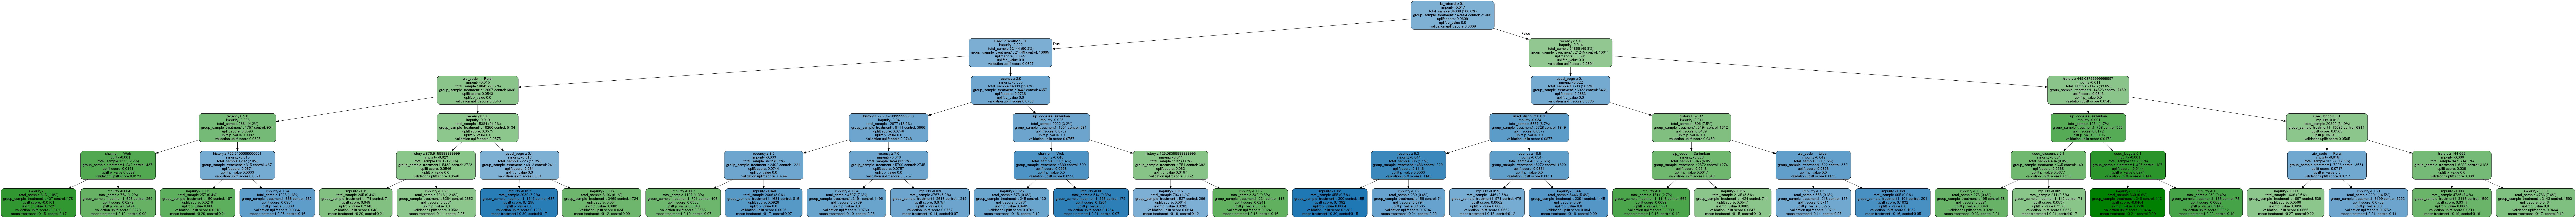

In [31]:
%%time
features = [col for col in df_1_f]
uplift_model = UpliftTreeClassifier(max_depth=6, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_1_f.values,
                 treatment=treatment.map({1: 'treatment1', 0: 'control'}).values,
                 y=target)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

1. Нельзя звонить:  
    1. Привлечен из реферального канала, использовал скидку,из сельской местности, сделал покупку более 5 месяцев, канал вэб  
    
2. Не имеет смысла звонить:  
    1.  Привлечен из реферального канала, использовал скидку,из сельтской местности, сделал покупку более 5 месяцев, канал не вэб  
    2.  Привлечен из реферального канала, использовал скидку,из сельской местности, сделал покупку менее 5 месяцев, олпатил больше 732 долларов  
    3. Привлечен из реферального канала, использовал скидку, не из сельской местности купил более 5 месяцев назад, оплатил более 877 долларов  
    
    
    
3. Нужно позвонить:  
    1. Привлечен из реферального канала, использовал скидку,из сельской местности, сделал покупку менее 5 месяцев, олпатил менее 732 долларов 
    2. Привлечен из реферального канала, использовал скидку, не из сельской местности купил более 5 месяцев назад, оплатил менее 877 долларов
    3. Привлечен из реферального канала, использовал скидку, не из сельской местности, купил менее 5 месяцев, пользовался акцией bogo  
    
    etc
    
    
    
    


для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
1) сделать прогноз и получить uplift для тестовой выборки  
2) отсортировать тестовую выборку по uplift по убыванию  
3) разбить на децили (pandas qcut вам в помощь)   
4) для каждого дециля посчитать среднюю conversion

In [33]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=6, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)
uplift_ct = ct.predict(X_val)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


In [77]:
analys_sm = pd.DataFrame()
analys_sm['uplift'] = sm_trmnt_preds - sm_ctrl_preds
analys_sm['target'] = y_val.values
analys_sm.sort_values('uplift',ascending=False,inplace=True)

In [78]:
analys_sm['decil'] = pd.qcut(analys_sm['uplift'],10,labels=[1,2,3,4,5,6,7,8,9,10])

In [79]:
analys_sm.groupby('decil').mean()

uplift    target
decil                    
1      0.030867  0.046787
2      0.038436  0.087038
3      0.043881  0.106250
4      0.048963  0.121250
5      0.053852  0.145000
6      0.058859  0.157500
7      0.064292  0.151875
8      0.070893  0.170625
9      0.079170  0.209375
10     0.096023  0.262500

построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

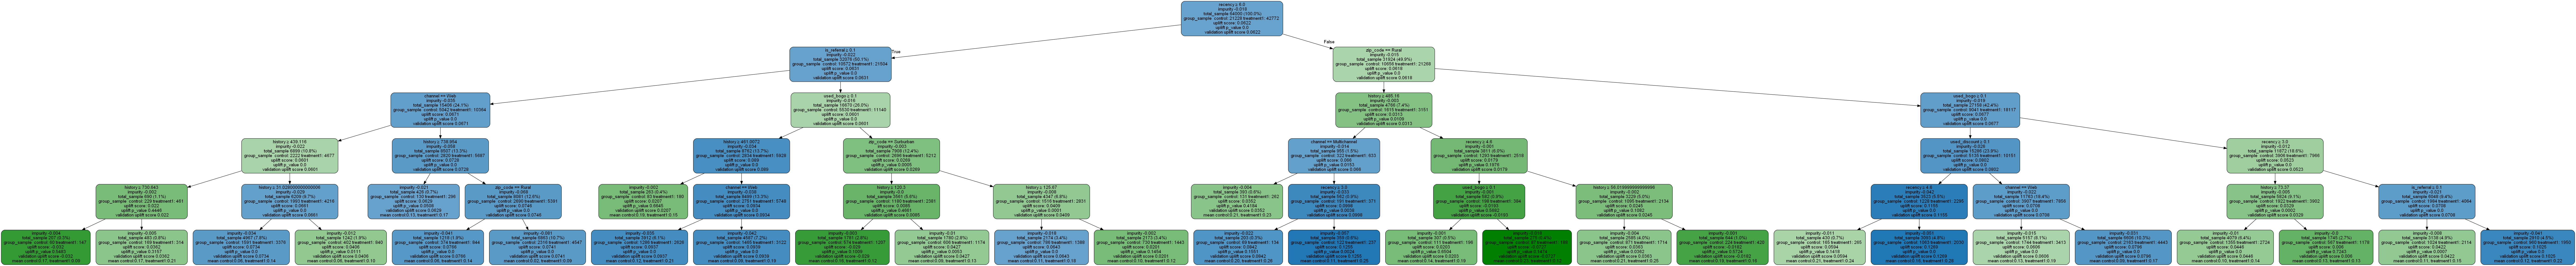

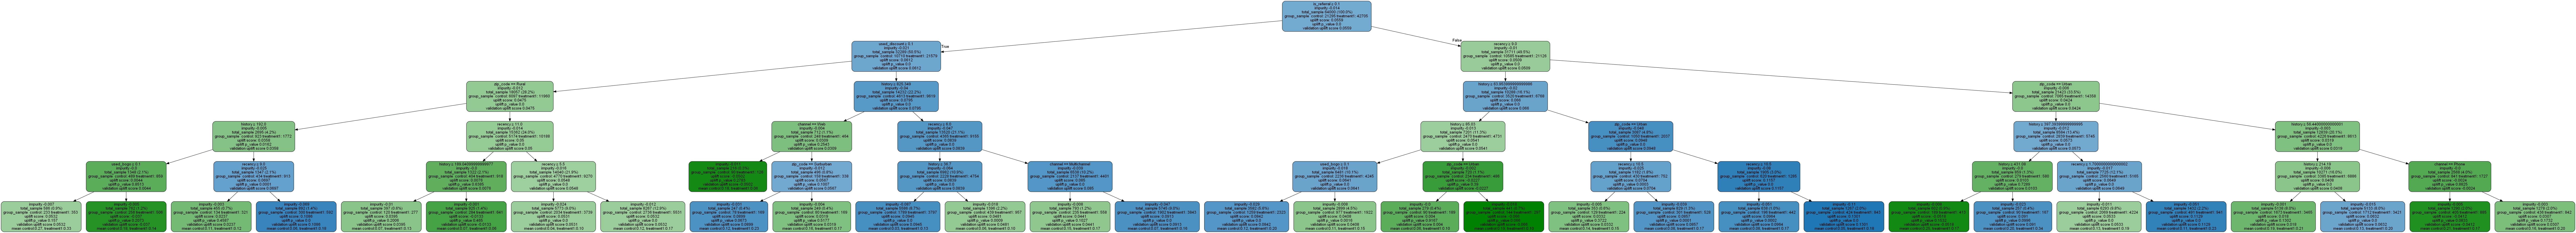

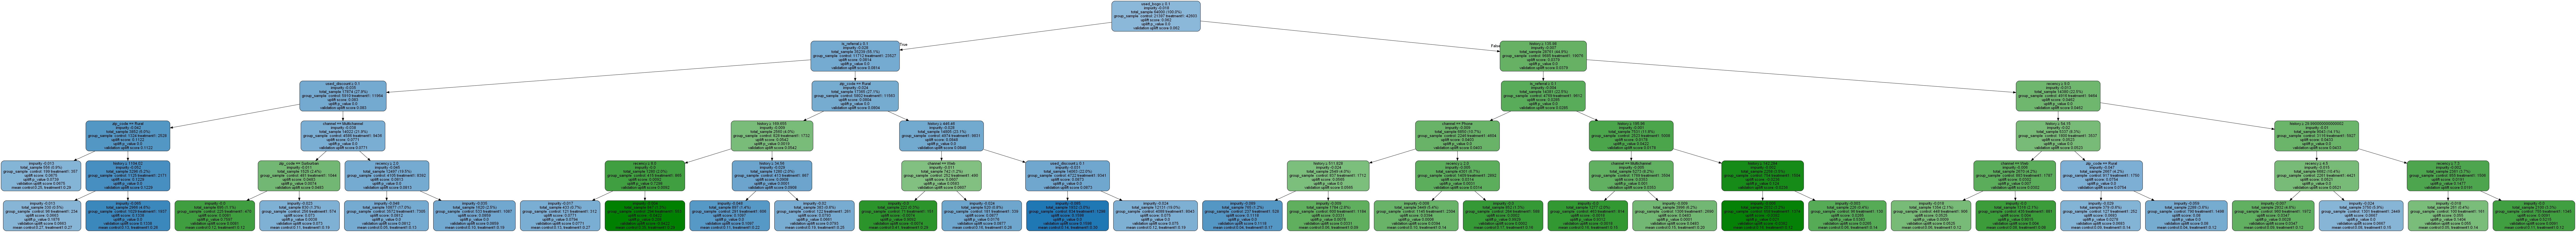

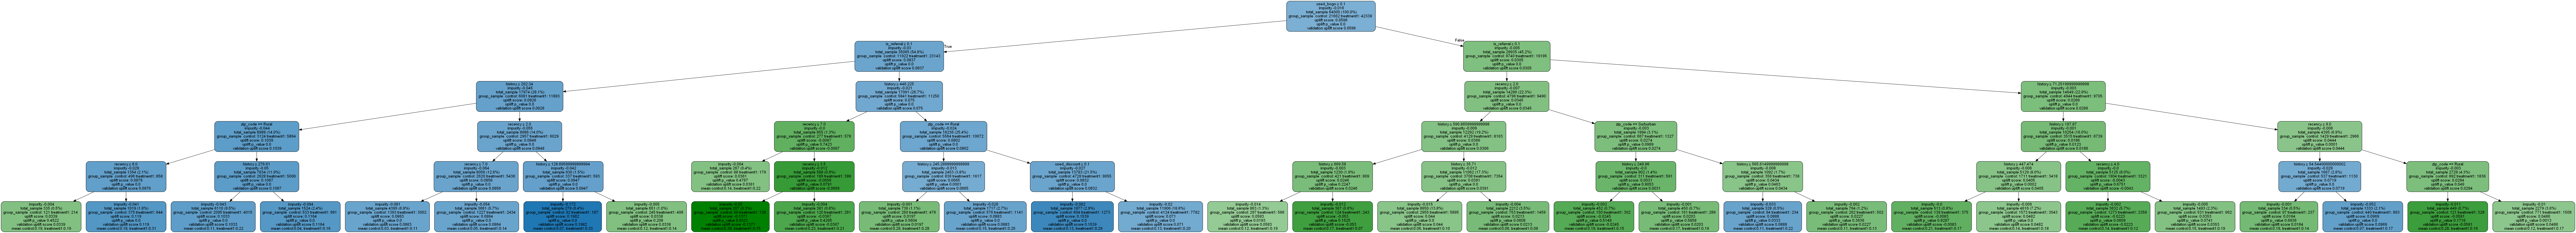

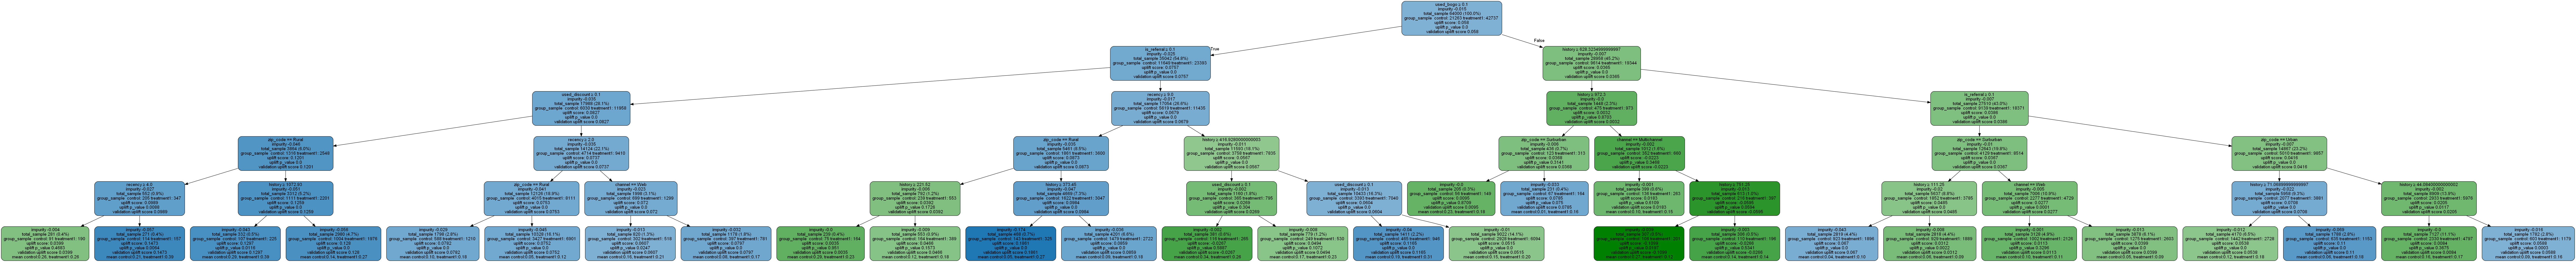

Wall time: 13.9 s


In [95]:
%%time
features = [col for col in df_1_f]
n_estimators = 5
uplift_model = UpliftRandomForestClassifier(max_depth=6, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, n_estimators = n_estimators, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_1_f.values,
                 treatment=treatment.map({1: 'treatment1', 0: 'control'}).values,
                 y=target)
for i in range(n_estimators):
    graph = uplift_tree_plot(uplift_model.uplift_forest[i].fitted_uplift_tree, features)
    display(Image(graph.create_png()))